## 1. Входные условия

### 1.1. Описание данных

1. ferma_main.csv - Текущие данные о коровах на ферме.

**Признаки:**

id — уникальный идентификатор коровы

**Характеристики коровы:**

Порода

порода папы_быка

Возраст (менее_2_лет / более_2_лет)

**Корм:**

ЭКЕ (энергетическая кормовая единица)

Сырой протеин, г

СПО (сахаро-протеиновое соотношение)

**Пастбище:**

Тип пастбища

**Молоко:**

Удой, кг

Жирность, %

Белок, %

Вкус молока (вкусно / не вкусно)


2. ferma_dad.csv - Информация об отцах коров.

**Признаки:**

id — уникальный идентификатор коровы

Имя Папы — имя отца коровы


3. cow_buy.csv - Коровы, которых фермер рассматривает для покупки (данные от «ЭкоФермы»).

**Признаки:**

Порода

Тип пастбища

порода папы_быка

Имя_папы

Текущая_жирность, %

Текущий_уровень_белок, %

Возраст (менее_2_лет / более_2_лет)

**Нет данных о корме и удое — их предстоит предсказать. При этом планируется увеличить ЭКЕ, протеин и СПО на 5%.**

### 1.2. Описание задачи

Фермер из хозяйства «Вольный луг» планирует расширить своё молочное стадо и заключил контракт с ассоциацией пастбищ «ЭкоФерма». В связи с этим он хочет тщательно отбирать коров на основе качества молока и продуктивности.

**Цель проекта:**

Разработать две модели машинного обучения, которые помогут фермеру принимать объективные решения о покупке новых коров:

* Модель прогнозирования удоя - Предсказывает, сколько килограммов молока будет давать корова в год 

* Модель оценки вкуса молока - Оценивает вероятность того, что молоко будет вкусным по внутренним критериям фермера

**Критерии отбора коров:**

* Средний годовой удой ≥ 6000 кг
* Молоко должно быть вкусным

## 2. Загрузка данных

### 2.1. Загрузка необходимых библиотек

In [1]:
 !pip install phik -q

In [2]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from scipy.stats import (
    binom,
    norm,
    pearsonr,
    spearmanr
)

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

import phik

### 2.2. Загрузка и первичный осмотр датафреймов

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ";")
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ";")
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ";")

display(ferma_main.head(5))

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [4]:
print(ferma_dad.head(5))

   id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин


In [5]:
display(cow_buy.head(5))

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


### 2.3. Информация о датафреймах

In [6]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

In [7]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [8]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


### 2.4. Выводы по разделу

Были просмотрены образцы из каждого датафрейма, а также выведена и проанализирована их общая информация. На данном этапе были выявлены следующие недостатки:

- Названия столбцов не соответствуют стандартам оформления.
- В ряде столбцов указан некорректный тип данных: числовые значения представлены в формате `object`.
- Столбцы с булевыми значениями представлены в виде строк.

Эти и другие потенциальные ошибки в данных будут рассотрены в разделах предобработки и исследовательского анализа данных

##  3. Предобработка данных

### 3.1. Проверка имен столбцов

In [9]:
ferma_main.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [10]:
ferma_main = ferma_main.rename(columns={'id' : 'id', 'Удой, кг' : 'volume', 'ЭКЕ (Энергетическая кормовая единица)' : 'efu',
       'Сырой протеин, г' : 'raw_protein', 'СПО (Сахаро-протеиновое соотношение)' : 'spr', 'Порода' : 'breed',
       'Тип пастбища' : 'pasture', 'порода папы_быка' : 'dad_breed', 'Жирность,%' : 'fat', 'Белок,%' : 'protein',
       'Вкус молока' : 'taste', 'Возраст' : 'age'})

In [11]:
ferma_dad.columns

Index(['id', 'Имя Папы'], dtype='object')

In [12]:
ferma_dad = ferma_dad.rename(columns={'id':'id', 'Имя Папы':'dad_name'})

In [13]:
cow_buy.columns

Index(['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст'],
      dtype='object')

In [14]:
cow_buy = cow_buy.rename(columns = {'Порода':'breed', 'Тип пастбища':'pasture', 'порода папы_быка':'dad_breed', 'Имя_папы':'dad_name',
       'Текущая_жирность,%':'current_fat', 'Текущий_уровень_белок,%':'current_protein', 'Возраст':'age'})

In [15]:
print(ferma_main.columns)
print(ferma_dad.columns)
print(cow_buy.columns)

Index(['id', 'volume', 'efu', 'raw_protein', 'spr', 'breed', 'pasture',
       'dad_breed', 'fat', 'protein', 'taste', 'age'],
      dtype='object')
Index(['id', 'dad_name'], dtype='object')
Index(['breed', 'pasture', 'dad_breed', 'dad_name', 'current_fat',
       'current_protein', 'age'],
      dtype='object')


### 3.2 Преобразование типов

В данном пункте необходимо многие объекты типа object преобразовать к типу float (числовые значения с запятыми), а бинарные значения необходимо заменить на int (преобразовать в 0 и 1)

#### 3.2.1 Приведение к типу float64

In [16]:
ferma_main['efu'] = ferma_main['efu'].str.replace(',', '.').astype('float64')
ferma_main['spr'] = ferma_main['spr'].str.replace(',', '.').astype('float64')
ferma_main['fat'] = ferma_main['fat'].str.replace(',', '.').astype('float64')
ferma_main['protein'] = ferma_main['protein'].str.replace(',', '.').astype('float64')
 
cow_buy['current_fat'] = cow_buy['current_fat'].str.replace(',', '.').astype('float64')
cow_buy['current_protein'] = cow_buy['current_protein'].str.replace(',', '.').astype('float64')

In [17]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           634 non-null    int64  
 1   volume       634 non-null    int64  
 2   efu          634 non-null    float64
 3   raw_protein  634 non-null    int64  
 4   spr          634 non-null    float64
 5   breed        634 non-null    object 
 6   pasture      634 non-null    object 
 7   dad_breed    634 non-null    object 
 8   fat          634 non-null    float64
 9   protein      634 non-null    float64
 10  taste        634 non-null    object 
 11  age          634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [18]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed            20 non-null     object 
 1   pasture          20 non-null     object 
 2   dad_breed        20 non-null     object 
 3   dad_name         20 non-null     object 
 4   current_fat      20 non-null     float64
 5   current_protein  20 non-null     float64
 6   age              20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


#### 3.2.2 Приведение к типу int64

In [19]:
ferma_main['taste'] = ferma_main['taste'].map(lambda x: 1 if x == 'вкусно' else 0).astype('int64')

In [20]:
ferma_main['age'] = ferma_main['age'].map(lambda x: 1 if x == 'более_2_лет' else 0).astype('int64')
cow_buy['age'] = cow_buy['age'].map(lambda x: 1 if x == 'более_2_лет' else 0).astype('int64')

In [21]:
#Checking
print(ferma_main['taste'].unique())
print(ferma_main['age'].unique())
print(cow_buy['age'].unique())

[1 0]
[1 0]
[1 0]


### 3.3. Обработка пропусков

In [22]:
ferma_main.isna().sum()

id             0
volume         0
efu            0
raw_protein    0
spr            0
breed          0
pasture        0
dad_breed      0
fat            0
protein        0
taste          0
age            0
dtype: int64

In [23]:
ferma_dad.isna().sum()

id          0
dad_name    0
dtype: int64

In [24]:
cow_buy.isna().sum()

breed              0
pasture            0
dad_breed          0
dad_name           0
current_fat        0
current_protein    0
age                0
dtype: int64

### 3.4. Обработка явных дубликатов

#### 3.4.1 ferma_main

In [25]:
ferma_main.duplicated().sum()

5

In [26]:
ferma_main[ferma_main.duplicated() == True]

,id,volume,efu,raw_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,0,1
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,0,1
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,0,1
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,0,1
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,0,1


Представленные дубликаты - полные повторения одной и той же коровы в количестве 5 штук. В данном случае удаляем дубликаты

In [27]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop= True)

#### 3.4.2 cow_buy

In [28]:
cow_buy.duplicated().sum()

4

In [29]:
cow_buy[cow_buy.duplicated() == True]

,breed,pasture,dad_breed,dad_name,current_fat,current_protein,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,1
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,1
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,1


В данном случае дубликаты также собой представляют повторное занесение в датасет полной информации о корове, данные дубликаты мы можем удалить, но оставим, поскольку повтор не гарантирован при данном наборе признаков

#### 3.4.3 ferma_dad

In [30]:
ferma_dad.duplicated().sum()

0

В данном датасете дубликатов не обнаружено, можно переходить к неявным дубликатам

### 3.5. Обработка неявных дубликатов

#### 3.5.1 ferma_main

In [31]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           629 non-null    int64  
 1   volume       629 non-null    int64  
 2   efu          629 non-null    float64
 3   raw_protein  629 non-null    int64  
 4   spr          629 non-null    float64
 5   breed        629 non-null    object 
 6   pasture      629 non-null    object 
 7   dad_breed    629 non-null    object 
 8   fat          629 non-null    float64
 9   protein      629 non-null    float64
 10  taste        629 non-null    int64  
 11  age          629 non-null    int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 59.1+ KB


In [32]:
print(ferma_main['breed'].unique())
print(ferma_main['pasture'].unique())
print(ferma_main['dad_breed'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']


In [33]:
ferma_main['pasture'] = ferma_main['pasture'].replace({'Равнинные':'Равнинное'})

In [34]:
ferma_main['dad_breed'] = ferma_main['dad_breed'].replace({'Айдиалл':'Айдиал'})

In [35]:
print(ferma_main['breed'].unique())
print(ferma_main['pasture'].unique())
print(ferma_main['dad_breed'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Холмистое']
['Айдиал' 'Соверин']


#### 3.5.2 ferma_dad

In [36]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [37]:
ferma_dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

#### 3.5.3 cow_buy

In [38]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed            20 non-null     object 
 1   pasture          20 non-null     object 
 2   dad_breed        20 non-null     object 
 3   dad_name         20 non-null     object 
 4   current_fat      20 non-null     float64
 5   current_protein  20 non-null     float64
 6   age              20 non-null     int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ KB


In [39]:
print(cow_buy['breed'].unique())
print(cow_buy['pasture'].unique())
print(cow_buy['dad_breed'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['холмистое' 'равнинное']
['Айдиал' 'Соверин']


В датасете ferma_main пастбища представлены в заглавном регистре, заменим здесь в тот же формат

In [40]:
cow_buy['pasture'] = cow_buy['pasture'].replace({'холмистое':'Холмистое','равнинное':'Равнинное'})

print(cow_buy['breed'].unique())
print(cow_buy['pasture'].unique())
print(cow_buy['dad_breed'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Холмистое' 'Равнинное']
['Айдиал' 'Соверин']


## 4. Исследовательский анализ данных

### 4.1 Распределения значений и проверка на аномалии

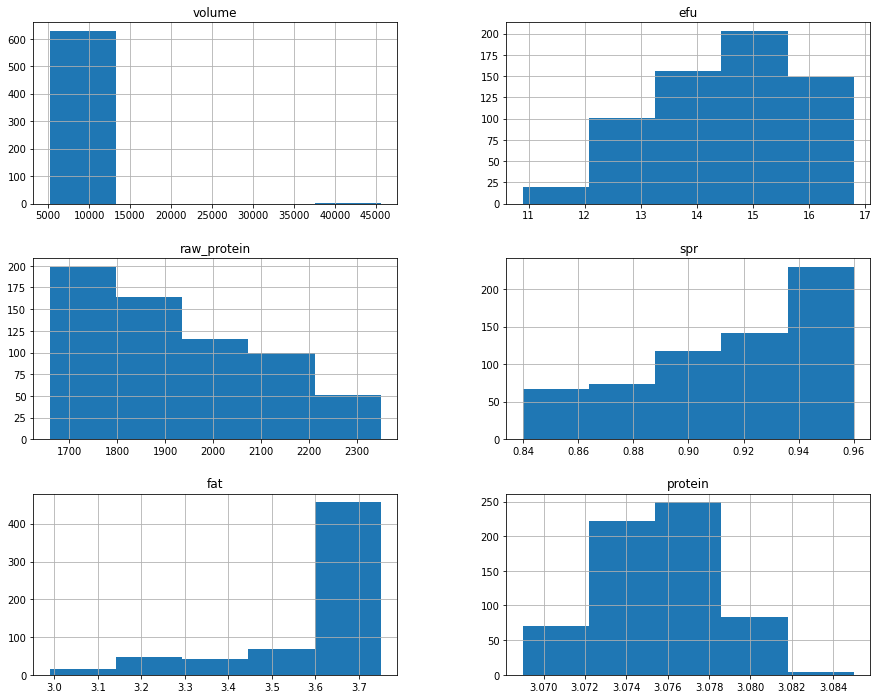

In [41]:
ferma_main[['volume', 'efu', 'raw_protein', 'spr', 'fat', 'protein']].hist(figsize=(15,12), bins = 5)
plt.show()

Volume (Удой)

Распределение объема напоминает нормальное распределение с пиком около 6250, но с небольшой левосторонней асимметрией. График имеет форму, близкую к колоколообразной, с одним выраженным пиком и постепенным снижением частоты в обе стороны от центрального значения. Однако заметен резкий спад в диапазоне 7000-7250, что делает распределение не полностью симметричным.

ЭКЕ

Распределение EFU близко к нормальному, с пиком в области значения 15. График симметричен относительно пика, имеет колоколообразную форму, хотя с левой стороны (значения 11-12) частота значительно ниже, что создает небольшую правостороннюю асимметрию.

Raw Protein (сырой белок)

Распределение необработанного белка не является нормальным. Наблюдается отчетливая правосторонняя асимметрия с пиком в области наименьших значений (около 1700). График монотонно убывает без центрального пика, характерного для нормального распределения.

СПО

Распределение SPR не соответствует нормальному. Наблюдается выраженная левосторонняя асимметрия с максимальной частотой в области наибольших значений (около 0.94-0.96). График не имеет центрального пика и не является симметричным.

Fat (Жир)

Распределение показателя жирности явно не является нормальным. График имеет сильную левостороннюю асимметрию с резким пиком в области максимальных значений (около 3.7). Такое распределение значительно отклоняется от колоколообразной формы.

Protein (Белок)

Распределение белка близко к нормальному, с пиком около значения 3.076. График имеет относительно симметричную колоколообразную форму с одним центральным пиком, хотя и наблюдается небольшая правосторонняя асимметрия.

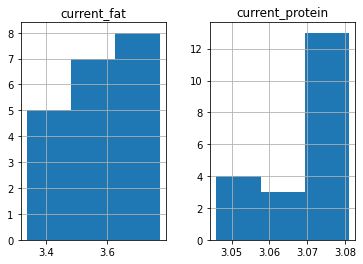

In [42]:
cow_buy[['current_fat', 'current_protein']].hist(bins = 3)
plt.show()

Current Fat (Текущий жир)

Распределение показателя текущего жира не соответствует нормальному распределению. График демонстрирует монотонно возрастающую тенденцию без центрального пика. Наблюдается отчетливая правосторонняя асимметрия с максимальной частотой в области наибольших значений (около 3.8). Форма распределения далека от колоколообразной, характерной для нормального распределения.

Current Protein (Текущий белок)

Распределение текущего белка также не является нормальным. График имеет бимодальный характер с двумя пиками - небольшой пик около значения 3.05 и значительно более высокий пик в области 3.08. Отсутствует симметричная колоколообразная форма, вместо этого наблюдается сильная правосторонняя асимметрия с концентрацией значений в верхнем диапазоне. Такое распределение существенно отклоняется от нормального.

Данные распределения показывают, что в данных встречается всего несколько очевидных аномалий, которые мы далее рассмотрим

**volume**

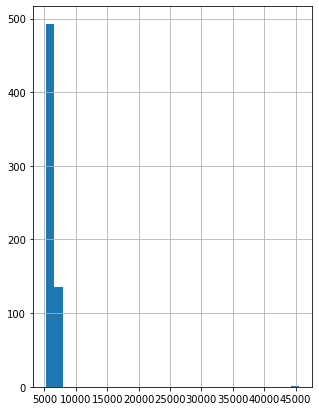

In [43]:
ferma_main['volume'].hist(figsize = (5, 7), bins = 30)
plt.show()

Здесь мы можем пронаблюдать выброс в районе больших значений. От него нужно избавиться

In [44]:
ferma_main[ferma_main['volume']>30000]

,id,volume,efu,raw_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,1,1


Выброс представлен одним аномальным значением, возникшим возможно из-за того, что удой представлен не в килограммах, а в граммах. В данном случае мы не можем однозначно работать с этой аномалией, поэтому мы ее удалим

In [45]:
ferma_main = ferma_main[ferma_main['volume'] < 10000]

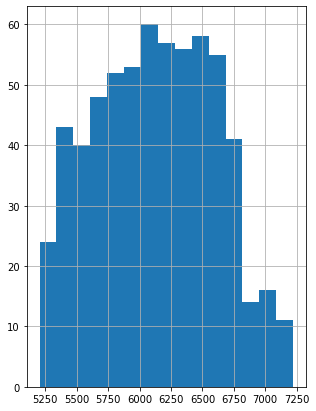

In [46]:
ferma_main['volume'].hist(figsize = (5, 7), bins = 15)
plt.show()

На данном этапе мы просмотрели распределения и убрали аномалию. Если есть какие-то данные, выбивающиеся из нормальных значений, они будут обработаны в дальнейшем.

### 4.2 Анализ данных

#### 4.2.1 ferma_main

In [47]:
ferma_main.describe()

,id,volume,efu,raw_protein,spr,fat,protein,taste,age
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670,0.589172,0.824841
std,181.475367,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551,0.492376,0.380406
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000,0.000000,0.000000
25%,158.750000,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000,0.000000,1.000000
50%,315.500000,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000,1.000000,1.000000
75%,472.250000,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000,1.000000,1.000000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000,1.000000,1.000000


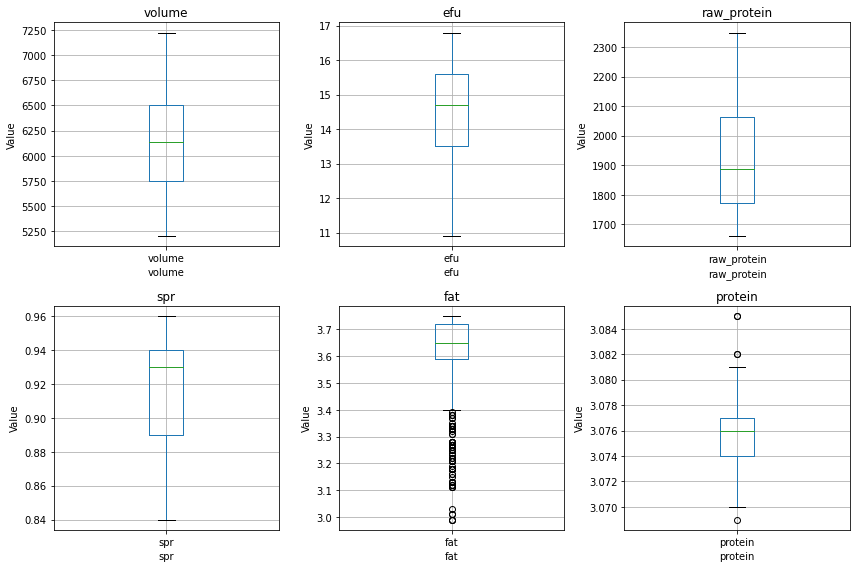

In [48]:
columns_to_plot = ['volume', 'efu', 'raw_protein', 'spr', 'fat', 'protein']
plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i + 1)
    ferma_main.boxplot(column=column, ax=plt.gca())
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

Мы получили описание численных значений и выявили выбросы в долях жира и белка. Необъодимо их убрать без потери ценности данных 

In [49]:
ferma_main = ferma_main[ferma_main['fat']>3.1]
ferma_main = ferma_main[(ferma_main['protein'] >3.070) & (ferma_main['protein'] < 3.082)]

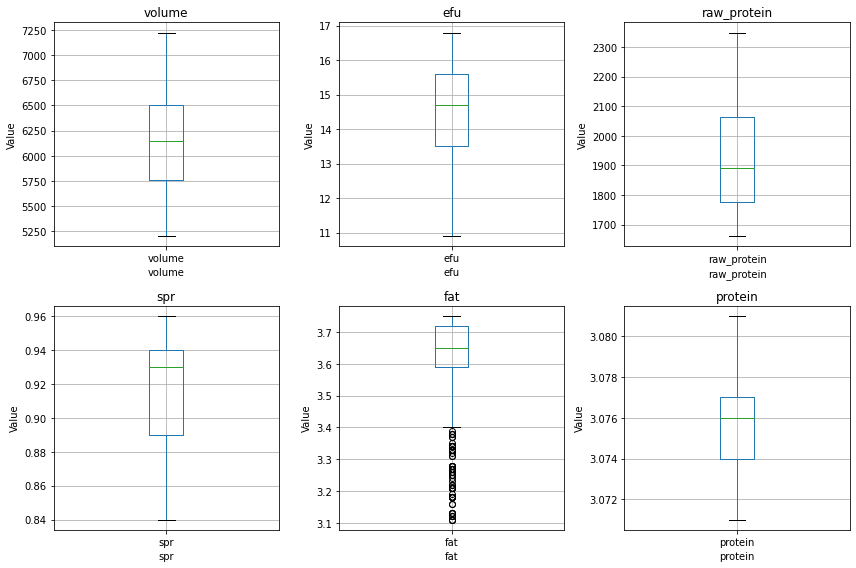

In [50]:
columns_to_plot = ['volume', 'efu', 'raw_protein', 'spr', 'fat', 'protein']
plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i + 1)
    ferma_main.boxplot(column=column, ax=plt.gca())
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

Все числовые параметры распределены в рамках нормального и в дальнейшем разборе не нуждаются, перейдем к разбору категориальных значений

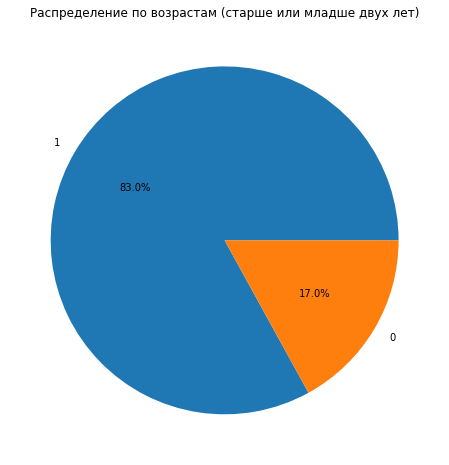

In [51]:
counts = ferma_main['age'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Распределение по возрастам (старше или младше двух лет)')
plt.show()

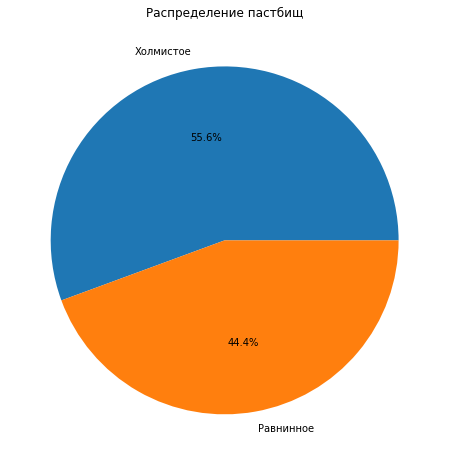

In [52]:
counts = ferma_main['pasture'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Распределение пастбищ')
plt.show()

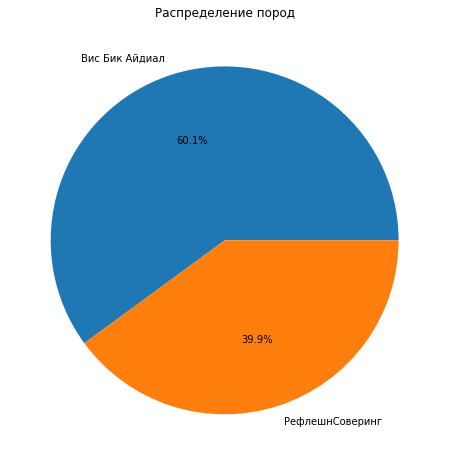

In [53]:
counts = ferma_main['breed'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Распределение пород')
plt.show()

#### 4.2.2 ferma_dad

Из-за отсутсвия числовых параметров в данном датасете в рамках анализа будет рассматриваться только используемость имен отцов

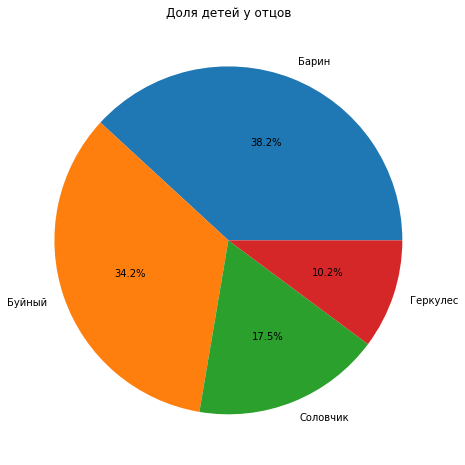

In [54]:
counts = ferma_dad['dad_name'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Доля детей у отцов')
plt.show()

#### 4.2.3 cow_buy

In [55]:
cow_buy.describe()

,current_fat,current_protein,age
count,20.000000,20.000000,20.000000
mean,3.577500,3.069500,0.750000
std,0.126818,0.010339,0.444262
min,3.340000,3.046000,0.000000
25%,3.510000,3.064000,0.750000
50%,3.590000,3.074000,1.000000
75%,3.650000,3.076000,1.000000
max,3.770000,3.081000,1.000000


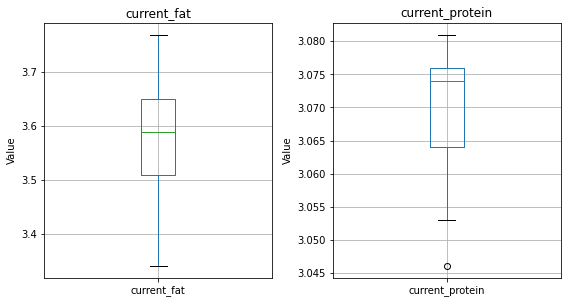

In [56]:
columns_to_plot = ['current_fat', 'current_protein']
plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i + 1)
    cow_buy.boxplot(column=column, ax=plt.gca())
    plt.title(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

ВСе численные значения в рамках нормальных и не содержат выбросы, можно переходить к категориальным значениям

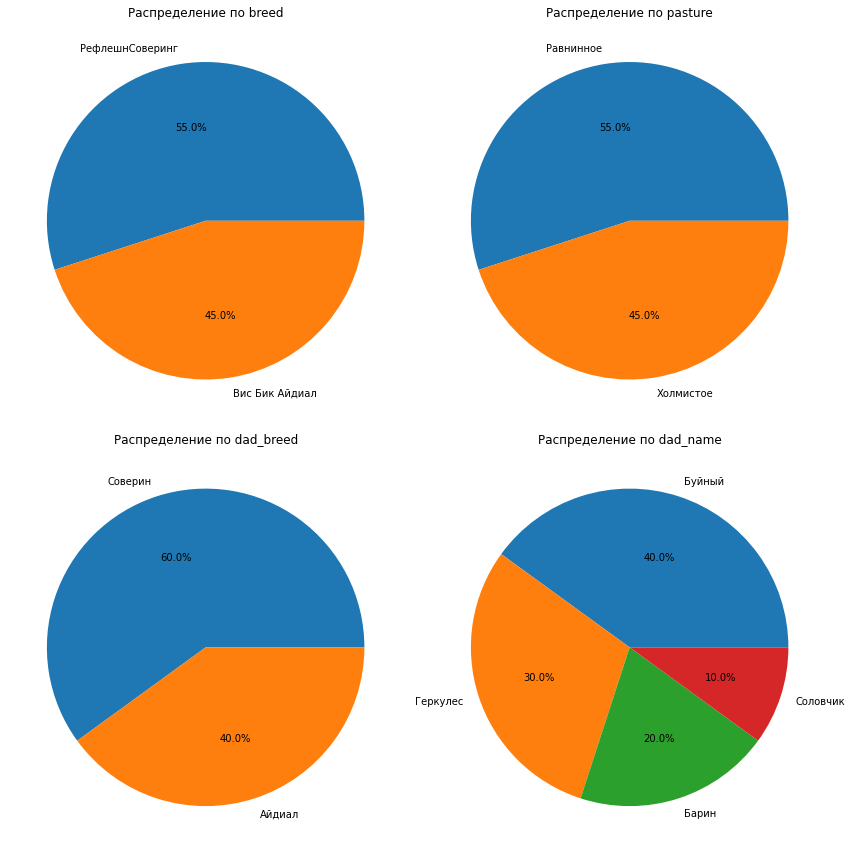

In [57]:
category = ['breed', 'pasture', 'dad_breed', 'dad_name']

plt.figure(figsize=(12, 12))

for i, cat in enumerate(category, start=1):
    plt.subplot(2, 2, i) 
    counts = cow_buy[cat].value_counts()
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
    plt.title(f'Распределение по {cat}')

plt.tight_layout()
plt.show()

Мы провели статистический анализ всех признаков из трёх датафреймов и построили соответствующие графики, учитывая тип каждой переменной. В процессе анализа были выявлены незначительные выбросы; наиболее критичные из них были удалены.

При анализе количественных переменных были построены гистограммы распределений. Основные наблюдения:

- Распределение показателя ЭКЕ близко к нормальному, но с небольшим смещением вправо.
- Распределение белка практически соответствует нормальному.
- Распределения СПО и жирности напоминают распределение Пуассона.
- Распределение сырого протеина также схоже с распределением Пуассона, но в отличие от СПО и жирности, частота значений убывает с ростом показателя.
- Распределение удоя также близко к нормальному.

## 5. Корреляционный анализ

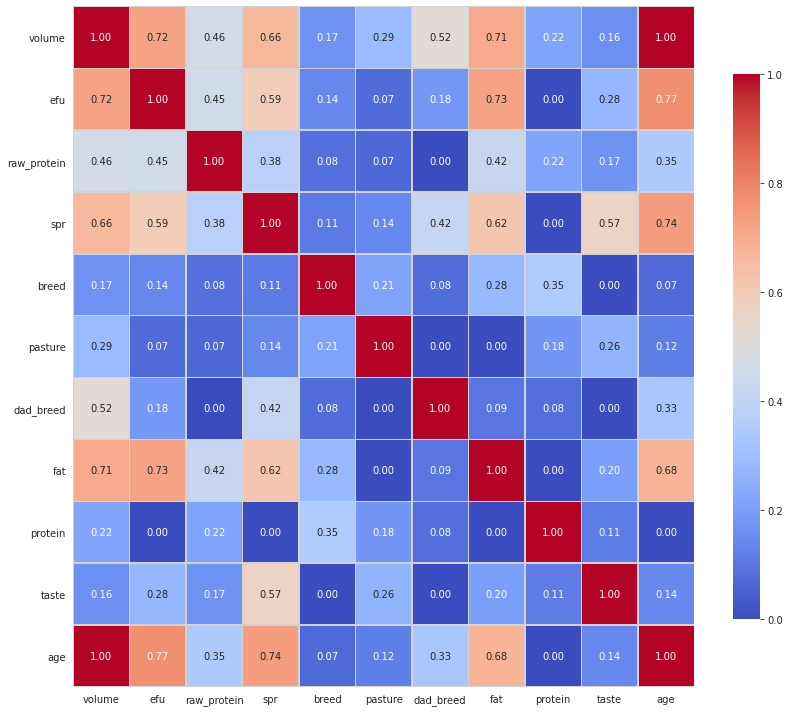

In [58]:
continuous_columns = ['volume', 'efu', 'raw_protein', 'spr', 'fat', 'protein']
phik_matrix = ferma_main.drop('id', axis=1, errors='ignore').phik_matrix(interval_cols=continuous_columns)

sns.set_style("white")
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    phik_matrix,
    annot=True,             
    fmt=".2f",              
    cmap="coolwarm",                               
    linewidths=.5,           
    linecolor='lightgray',  
    cbar_kws={'shrink': 0.8}
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

Подготовим функции для выявления корреляций, используя корреляционные коэффиценты Пирсона и Спирмана

Выбор между коэффициентами корреляции Пирсона и Спирмана зависит от природы данных и характера взаимосвязи между переменными:

- **Коэффициент Пирсона** применяется в случае, если:
  - переменные являются количественными;
  - взаимосвязь предполагается линейной;
  - данные распределены нормально (или близки к нормальному распределению);
  - отсутствуют существенные выбросы.

- **Коэффициент Спирмана** используют, если:
  - переменные можно ранжировать (порядковые или количественные данные);
  - предполагаемая зависимость — монотонная, но не обязательно линейная;
  - распределение переменных может отличаться от нормального;
  - в данных присутствуют выбросы или нарушения линейности.

In [59]:
def corr_Spearman(a, b, c):

    a.plot(kind='scatter', x=b, y=c)
    corr_spearman, a_corr_spearman = spearmanr(a[b], a[c])
    plt.xlabel(f'{b}', fontsize=12)
    plt.ylabel(f'{c}', fontsize=12)
    plt.suptitle(f'Диаграммы рассеяния между\n {b} и {c}', fontsize=12)
    print(f'Коэффициент корреляции Спирмена = {round(corr_spearman,2)}\nзначение p = {a_corr_spearman}')

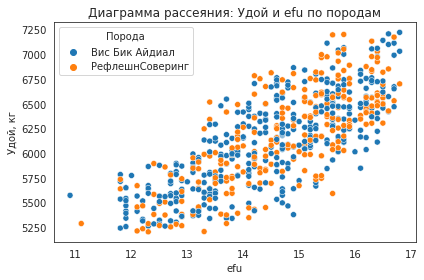

efu: Коэффициент Пирсона = 0.77, p-value = 9.381e-118


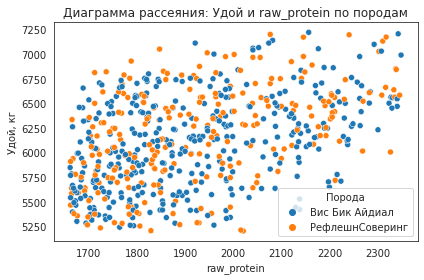

raw_protein: Коэффициент Пирсона = 0.44, p-value = 4.853e-30


In [60]:
columns = ['efu', 'raw_protein']
for col in columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=ferma_main, x=col, y='volume', hue='breed')
    plt.title(f'Диаграмма рассеяния: Удой и {col} по породам')
    plt.xlabel(col)
    plt.ylabel('Удой, кг')
    plt.legend(title='Порода')
    plt.tight_layout()
    plt.show()
    r, p_value = pearsonr(ferma_main[col], ferma_main['volume'])
    print(f"{col}: Коэффициент Пирсона = {r:.2f}, p-value = {p_value:.3e}")

Данные диаграммы рассеяния показали сильную линейную зависимость ЭКЕ и Удоя, а также среднюю зависимость сырого белка в корме и Удоя

Коэффициент корреляции Спирмена = 0.78
значение p = 1.2424346893568495e-126
Коэффициент корреляции Спирмена = 0.68
значение p = 4.837876681304348e-84
Коэффициент корреляции Спирмена = -0.01
значение p = 0.7950762858087888


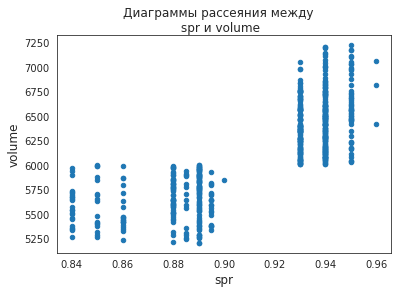

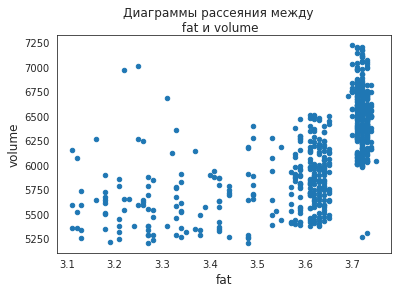

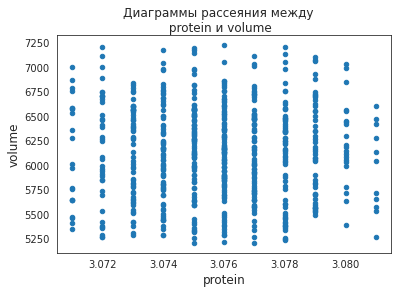

In [61]:
columns = ['spr', 'fat', 'protein']
for col in columns:
    corr_Spearman(ferma_main, col, 'volume')

Данные тесты показывают высокую корреляцию между СПО и Удоем и корреляцию выше среднего между жирами и Удоем. Взаимосвязь же белка и удоя практически равна 0

Исследование показало следующее:

- Целевой признак "Удой молока" имеет линейную зависимость с признаками "ЭКЕ (Энергетическая кормовая единица)" и "Сырой протеин, г".
- Зависимость между "Удоем молока" и остальными признаками является нелинейной.
- Признаков мультиколлинеарности не выявлено. Обычно о наличии мультиколлинеарности говорят при значении коэффициента корреляции между признаками в диапазоне от 0.9 до 0.95 и выше.


## 6. Обучение модели линейной регрессии

Построим модель машинного обучения для предсказания целевого признака - Удоя

### 6.1 Первая модель

Начнем с отбора характеристик которые будем считать как вводные для обучения на них нашей модели

Изучив получившиеся матрицы корреляции можно прийти к выводу, что больше всего влияют на целевую переменную параметры СПО, ЭКЕ, возраст и сырой протеин, а также порода коровы и отца, поскольку разные породы имеют свои особенности, в том числе удой + может сыграть наследственность

Также как дополнительные признаки добавим тип пастбища, поскольку условия также могут влиять на удой

Жирность не учитываем из-за необходимости преобразований и нелинейной зависимости

In [62]:
RANDOM_STATE = 42

X = ferma_main[['spr','age','raw_protein','efu', 'breed', 'dad_breed', 'pasture']].copy()
y = ferma_main['volume']

X_train, X_test, y_train, y_test1 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

Теперь закодируем категориальные признаки и масштабируем численные

In [63]:
cat_col_names = ['age', 'breed', 'dad_breed', 'pasture']
num_col_names = ['raw_protein', 'spr', 'efu']

encoder = OneHotEncoder(sparse=False,drop='first')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_names])

X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Теперь обучим модель МО и проверим ее работоспособность

In [64]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)

predictions1 = model_lr.predict(X_test)

print(predictions1[0], y_test1.reset_index().loc[0, 'volume'])

5612.008195860114 5544


Оценим работу модели через R2 

In [65]:
r2 = r2_score(y_test1, predictions1)
print('R2 LinearRegression =', r2)

R2 LinearRegression = 0.7711859005230479


Посмотрим также на распредедение остатков

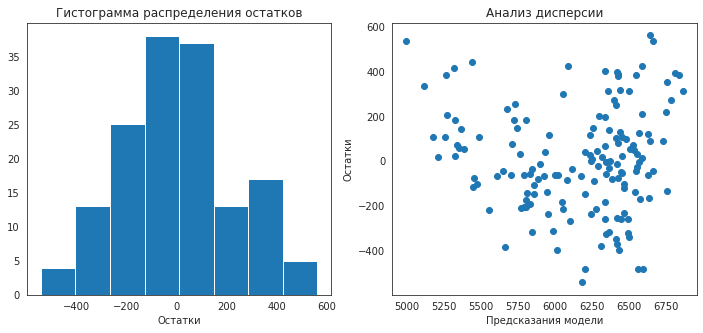

In [66]:
errors = y_test1 - predictions1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axes[0].hist(errors, bins = 8)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions1, errors)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Выводы:

- Метрика \( R^2 \) показала относительно хороший результат — 0.76, но при анализе остатков не было получено нормальное распределение.
- Также при анализе дисперсии была замечена форма "дуги", что указывает на возможную нелинейную зависимость одного из признаков с целевым.
- Такая модель не может быть использована в работе. Требуется повторное изучение всех признаков и их преобразование для достижения линейной зависимости.


### 6.2 Вторая модель

Мы обнаружили 2 признака, которые нелинейно связаны с целевым - ЭКЕ и СПО.

На графике СПО явно видно, что его будет легче анализировать, преобразовав количественные значения в категироальные, разлелив их на 2 группы по интервалам.

ЭКЕ имеет квадратичную зависимость(график в виде параболы), и добиться линейности мы можем возведя значения в квадрат

Начать легче с преобразования СПО

Для преобразования СПО из количественного в категориальное значение, легче будет использовать разделение на кластеры. Как мы можем увидеть по графику корреляции, разделеение можно произвести по границе 0.91 по принципу больше-меньше

In [67]:
ferma_main['spr_cat'] = (ferma_main['spr'] > 0.91).astype(int)

Далее преобразуем ЭКЕ

In [68]:
ferma_main['efu'] = ferma_main['efu']**2

Учим модель еще раз, учитывая новые преобразования

In [69]:

X = ferma_main[['spr_cat','age','raw_protein', 'efu', 'breed', 'dad_breed', 'pasture']].copy()

y = ferma_main['volume']


X_train, X_test, y_train, y_test2 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)


cat_col_names = ['age', 'breed', 'dad_breed', 'pasture','spr_cat']
num_col_names = ['raw_protein','efu']

encoder = OneHotEncoder(sparse=False,drop='first')

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = scaler.fit_transform(X_train[num_col_names])

X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)

predictions2 = model_lr.predict(X_test)


print(predictions2[0], y_test2.reset_index().loc[0, 'volume'])

5515.792467046402 5544


Оценим работу модели по метрике и распределению ошибок

In [70]:
r2 = r2_score(y_test2, predictions2)
print('R2 LinearRegression =', r2)

R2 LinearRegression = 0.8046050113444032


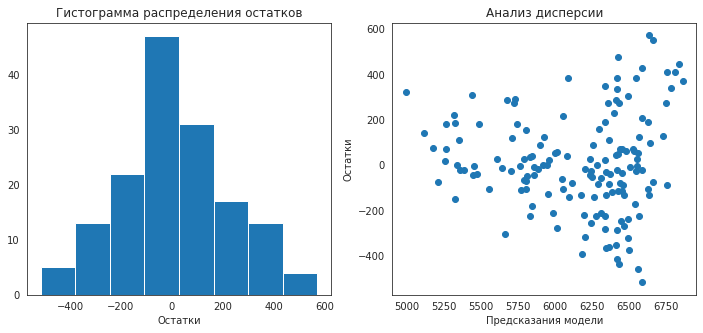

In [71]:
errors = y_test2 - predictions2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axes[0].hist(errors, bins = 8)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions1, errors)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Мы получили новые показатели метрики и новые графики остатков. Результаты такие, что r2 увеличился и стал равен 0.80. На гистограмме же получислось распределение, которое больше схоже с нормальным, чем было до этого, а дисперсия осталась  неравномерной. Следовательно, модель все еще не идеальна.

### 6.3 Третья модель

In [72]:
ferma = pd.merge(ferma_main, ferma_dad, on='id', how='left')

In [73]:
X = ferma[['spr_cat','age','raw_protein', 'efu', 'breed', 'dad_breed', 'pasture', 'dad_name']].copy()

y = ferma['volume']


X_train, X_test, y_train, y_test3 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)


cat_col_names = ['dad_breed', 'age', 'dad_name', 'pasture', 'breed']
num_col_names = ['raw_protein','efu', 'spr_cat']


encoder = OneHotEncoder(sparse=False,drop='first')

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])


X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()



X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)


X_train_scaled = scaler.fit_transform(X_train[num_col_names])

X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)


X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)


predictions3 = model_lr.predict(X_test)


print(predictions3[0], y_test3.reset_index().loc[0, 'volume'])

5532.3035394310255 5544


In [74]:
r2 = r2_score(y_test3, predictions3)
print('R2 LinearRegression =', r2)

R2 LinearRegression = 0.8264143976492457


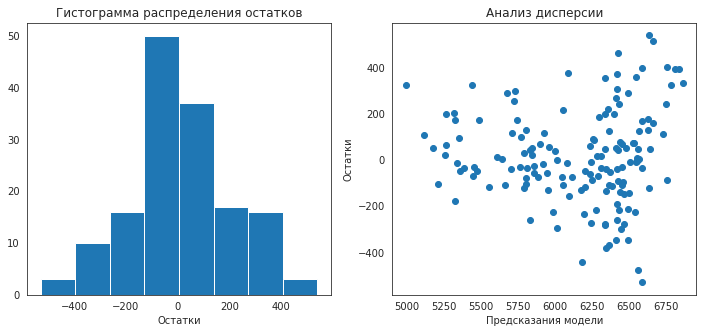

In [75]:
errors = y_test3 - predictions3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axes[0].hist(errors, bins = 8)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions1, errors)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Мы обучили третью модель, добавив признак имя папы. У нас улучшилась метрика r2 - значение достигло почти 0.83, гистаграмма распределения остатков приняла почти идеально нормальный вид. Анализ же диспергии все еще указывает на неидеальную точность модели

### 6.4 Остальные Метрики

In [76]:
mse1 = mean_squared_error(y_test1, predictions1)
rmse1 = mean_squared_error(y_test1, predictions1, squared=False) 
mae1 = mean_absolute_error(y_test1, predictions1)

mse2 = mean_squared_error(y_test2, predictions2)
rmse2 = mean_squared_error(y_test2, predictions2, squared=False) 
mae2 = mean_absolute_error(y_test2, predictions2)

mse3 = mean_squared_error(y_test3, predictions3)
rmse3 = mean_squared_error(y_test3, predictions3, squared=False) 
mae3 = mean_absolute_error(y_test3, predictions3)

print('MSE, RMSE, MAE для 1 модели:', mse1,rmse1,mae1)
print('MSE, RMSE, MAE для 2 модели:', mse2,rmse2,mae2)
print('MSE, RMSE, MAE для 3 модели:', mse3,rmse3,mae3)

MSE, RMSE, MAE для 1 модели: 54078.797218356536 232.54848358644813 183.95512239797728
MSE, RMSE, MAE для 2 модели: 46180.397069689585 214.89624722104756 164.5943613768402
MSE, RMSE, MAE для 3 модели: 41025.88350547985 202.54847198999022 155.66499888551175


По метрикам, представленным в данном пункте, а также R2 можно сделать вывод о том, что самой точной моделью является третья. Далее рассчитаем доверительный интервал прогноза для данной модели

In [77]:
errors = y_test3 - predictions3
quantiles=(0.025, 0.975)

lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")

Доверительный интервал прогноза: [-370.3266818254647, 400.9404118408677]


### 6.5 Прогноз удоя

In [78]:
cow_buy['mean_efu'] = ferma_main['efu'].mean()*1.1025
cow_buy['mean_raw_protein'] = ferma_main['raw_protein'].mean()*1.05
cow_buy['mean_spr'] = (ferma_main['spr'].mean()*1.05 >0.91).astype(int)

In [79]:
cow_buy.head(5)

,breed,pasture,dad_breed,dad_name,current_fat,current_protein,age,mean_efu,mean_raw_protein,mean_spr
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,235.617367,2022.287871,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,235.617367,2022.287871,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,235.617367,2022.287871,1


In [80]:
cat_col_names = ['dad_breed', 'age', 'dad_name', 'pasture', 'breed']
num_col_names = ['mean_raw_protein','mean_efu', 'mean_spr']

cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
encoder_col_names = encoder.get_feature_names()
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)

cow_buy_scaled = scaler.transform(cow_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

cow_buy_prepared = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

predicted_volume = model_lr.predict(cow_buy_prepared)
cow_buy['volume'] = predicted_volume
cow_buy

,breed,pasture,dad_breed,dad_name,current_fat,current_protein,age,mean_efu,mean_raw_protein,mean_spr,volume
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,235.617367,2022.287871,1,6298.649475
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1,6295.682374
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,235.617367,2022.287871,1,6592.153752
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,235.617367,2022.287871,1,6531.277829
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,235.617367,2022.287871,1,6358.637911
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,1,235.617367,2022.287871,1,6531.113341
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1,6295.682374
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,235.617367,2022.287871,1,6359.689887


Мы получили прогнозируемый удой для всех коров, доступных к покупке. Он представлен на таблице

Критерии отбора:
- Средний годовой удой ≥ 6000 кг
- Молоко должно быть вкусным

Анализ подходящих коров по удою

На основе обновленных данных из таблицы и с учетом доверительного интервала прогноза [-370.33, 400.94] кг, проведем оценку коров:

1. Коровы, с высокой устойчивостью к риску ошибки модели:
Учитывая нижнюю границу доверительного интервала (-370.33 кг), подходящими с высокой вероятностью являются коровы с удоем от 6370.33 кг и выше:
- Строка 0: Вис Бик Айдиал, Геркулес - 6613.90 кг
- Строка 3: Рефлешн Соверинг, Буйный - 6592.15 кг
- Строка 4: Рефлешн Соверинг, Буйный - 6531.28 кг
- Строка 6: Вис Бик Айдиал, Геркулес - 6613.90 кг
- Строка 7: Вис Бик Айдиал, Буйный - 6531.11 кг
- Строка 11: Рефлешн Соверинг, Геркулес - 6591.10 кг
- Строка 12: Вис Бик Айдиал, Геркулес - 6613.90 кг
- Строка 15: Рефлешн Соверинг, Буйный - 6592.15 кг
- Строка 18: Вис Бик Айдиал, Буйный - 6531.11 кг
- Строка 19: Рефлешн Соверинг, Буйный - 6531.28 кг

**Итого коров с высокой устойчивостью к ошибке: 10 из 20 (50%).**

2. Коровы с риском ошибки при отборе:
Коровы с удоем от 6000 кг до 6370.33 кг имеют риск не соответствовать требованию из-за возможной отрицательной границы доверительного интервала:
- Строка 1: Вис Бик Айдиал, Буйный - 6298.64 кг
- Строка 2: Рефлешн Соверинг, Барин - 6295.68 кг
- Строка 5: Рефлешн Соверинг, Геркулес - 6358.64 кг
- Строка 8: Рефлешн Соверинг, Барин - 6295.68 кг
- Строка 9: Рефлешн Соверинг, Буйный - 6359.69 кг
- Строка 10: Вис Бик Айдиал, Соловник - 6347.53 кг
- Строка 13: Вис Бик Айдиал, Барин - 6104.97 кг
- Строка 14: Рефлешн Соверинг, Барин - 6295.68 кг
- Строка 16: Вис Бик Айдиал, Соловник - 6347.53 кг
- Строка 17: Рефлешн Соверинг, Геркулес - 6358.64 кг

**Итого коров с риском ошибки: 10 из 20 (50%).**

## 7. Обучение модели логистической регрессии

### 7.1 Обучение и настройка модели

Обновим матрицу корреляции, чтобы выявить признаки, наиболее связанные с целевым признаком - вкусом молока

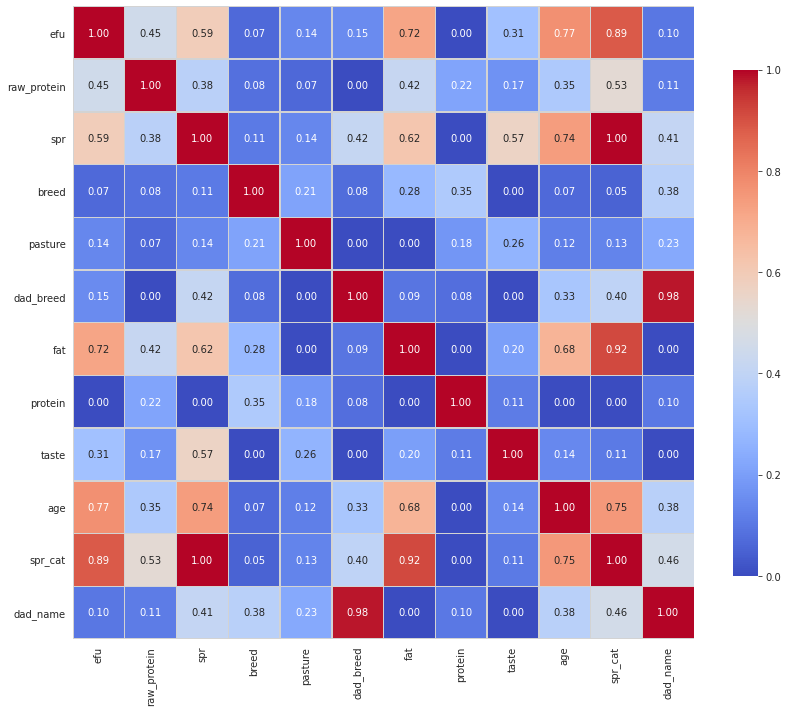

In [81]:
continuous_columns = ['volume', 'efu', 'raw_protein', 'spr', 'fat', 'protein']
phik_matrix = ferma.drop(['id', 'volume'],axis=1, errors='ignore').phik_matrix(interval_cols=continuous_columns)

sns.set_style("white")
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    phik_matrix,
    annot=True,             
    fmt=".2f",              
    cmap="coolwarm",                               
    linewidths=.5,           
    linecolor='lightgray',  
    cbar_kws={'shrink': 0.8}
)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

Из представленных параметров более всего влияют показатели ЭКЕ, СПО, тип пастбища и количество жира, а также сырого белка

Необходимо преобразовать ЭКЕ в ЭКЕ в квадрате, а СПО в бинарный формат по аналогии с предыдущим пунктом

In [82]:
ferma.head()

,id,volume,efu,raw_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_cat,dad_name
0,1,5863,201.64,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1,1,0,Буйный
1,2,5529,163.84,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,1,0,0,Соловчик
2,3,5810,196.00,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0,1,0,Барин
3,4,5895,153.76,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0,1,0,Буйный
4,5,5302,163.84,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,1,0,0,Барин


Далее проведем масштабирование и кодировку данных

In [83]:
cat_col_names = ['pasture', 'age', 'spr_cat']
num_col_names = ['fat','efu', 'raw_protein']

encoder = OneHotEncoder(sparse=False, drop='first')
ferma_ohe = encoder.fit_transform(ferma[cat_col_names])
encoder_col_names = encoder.get_feature_names()
ferma_ohe = pd.DataFrame(ferma_ohe, columns=encoder_col_names)

ferma_scaled = scaler.fit_transform(ferma[num_col_names])
ferma_scaled = pd.DataFrame(ferma_scaled, columns=num_col_names)

ferma_prepared= pd.concat([ferma_ohe, ferma_scaled], axis=1)
ferma_prepared['taste'] = ferma['taste']

In [84]:
ferma_prepared.head()

,x0_Холмистое,x1_1,x2_1,fat,efu,raw_protein,taste
0,0.0,1.0,0.0,-0.193418,-0.323597,-0.999945,1
1,0.0,0.0,0.0,-0.446986,-1.336857,1.158543,1
2,1.0,1.0,0.0,-0.130027,-0.474782,-0.393383,0
3,1.0,1.0,0.0,-1.334472,-1.607060,0.470012,0
4,0.0,0.0,0.0,0.757460,-1.336857,-1.371533,1


In [85]:
X = ferma_prepared[['x0_Холмистое', 'x2_1','fat', 'efu', 'raw_protein', 'x1_1']]
y = ferma_prepared['taste']
RANDOM_STATE = 42

X_train, X_test, y_train, y_test5 = train_test_split(X, y, random_state = RANDOM_STATE)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Выведем веса признаков

In [86]:
for feature_number, feature_name in enumerate(X.columns):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.2f}")

x0_Холмистое        : +1.79
x2_1                : +0.67
fat                 : +0.86
efu                 : +1.87
raw_protein         : +1.25
x1_1                : +0.93


Далее выведем метрики данной модели, матрицу ошибок и выберем метрику, необходимую для решения нашей задачи

In [87]:
acc = accuracy_score(y_test5, y_pred)
pre = precision_score(y_test5, y_pred)
rec = recall_score(y_test5, y_pred)

print(f'Метрика accuracy = {acc}, precision = {pre}, recall = {rec}')

Метрика accuracy = 0.6381578947368421, precision = 0.6481481481481481, recall = 0.8045977011494253


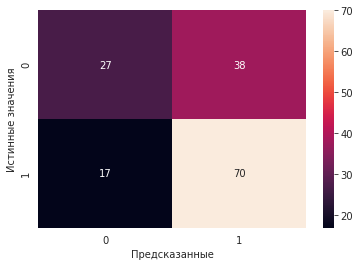

In [88]:
cm = confusion_matrix(y_test5, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные'); 

Так как наша задача - определить коров с вкусным молоком, для нас важнее избавиться от тех ошибок, где коровы дают невкусное молоко, а модель предсказала вкусное, так как мы приобретаем "некачественных" коров. Для исправления этих ошибок нам поможет метрика **precision**, которую необходимо максимизировать

In [89]:
y_proba = clf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.7, 0.9, num=50, endpoint=True)

results = []

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test5, y_pred).ravel()
    precision = round(tp / (tp + fp), 3) if tp+fp != 0 else None
    recall = round(tp / (tp + fn), 3) if tp+fn != 0 else None
    results.append({
        'Порог': f'{round(threshold, 3)}',
        'precision': precision,
        'recall':round(recall, 3),
        'False Negative': fn,
        'False Positive': fp,
        'True positive': tp
    })

results_df = pd.DataFrame(results)
print(results_df)

    Порог  precision  recall  False Negative  False Positive  True positive
0     0.7      0.810   0.391              53               8             34
1   0.704      0.810   0.391              53               8             34
2   0.708      0.810   0.391              53               8             34
3   0.712      0.800   0.368              55               8             32
4   0.716      0.795   0.356              56               8             31
5    0.72      0.784   0.333              58               8             29
6   0.724      0.778   0.322              59               8             28
7   0.729      0.765   0.299              61               8             26
8   0.733      0.788   0.299              61               7             26
9   0.737      0.774   0.276              63               7             24
10  0.741      0.800   0.276              63               6             24
11  0.745      0.793   0.264              64               6             23
12  0.749   

В данном случае наиболее походящий порог = 0.798

Precision at threshold 0.798: 1.00
0.12643678160919541


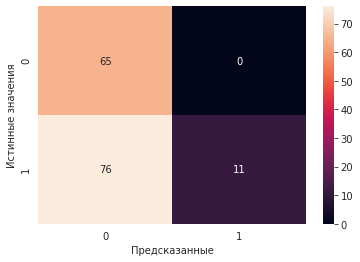

In [90]:
optimal_threshold = 0.798

y_pred = (y_proba >= optimal_threshold).astype(int)

precision = precision_score(y_test5, y_pred)
print(f'Precision at threshold {optimal_threshold}: {precision:.2f}')
recall = recall_score(y_test5, y_pred)
print(recall)
cm = confusion_matrix(y_test5, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные'); 

Мы подобрали пороговое значение 0.798, при котором количество ошибок первого рода стало равным нулю. При этом precision достиг 1, однако recall оказался равен приблизительно 0.13. Это указывает на низкую способность модели выявлять все случаи вкусного молока, но при этом она гарантированно не классифицирует невкусное молоко как вкусное, что является приоритетной задачей.

**Дальнейшие шаги:**
Необходимо улучшить модель так, чтобы при сохранении высокого precision также повысить значение recall. Для этого следует расширить обучающую и тестовую выборки за счёт добавления релевантных признаков

### 7.2 Предсказание вкуса молока

In [91]:
cow_buy.head()

,breed,pasture,dad_breed,dad_name,current_fat,current_protein,age,mean_efu,mean_raw_protein,mean_spr,volume
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,235.617367,2022.287871,1,6298.649475
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1,6295.682374
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,235.617367,2022.287871,1,6592.153752
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,235.617367,2022.287871,1,6531.277829


In [92]:
cat_col_names = ['pasture', 'age', 'mean_spr']
num_col_names = ['current_fat', 'mean_efu', 'mean_raw_protein']

cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
encoder_col_names = encoder.get_feature_names()
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns = encoder_col_names)

cow_buy_scaled = scaler.transform(cow_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns = num_col_names)

cow_buy_prepared = pd.concat([cow_buy_ohe, cow_buy_scaled], axis = 1)
cow_buy['taste'] = clf.predict(cow_buy_prepared)
cow_buy

,breed,pasture,dad_breed,dad_name,current_fat,current_protein,age,mean_efu,mean_raw_protein,mean_spr,volume,taste
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,235.617367,2022.287871,1,6298.649475,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1,6295.682374,0
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,235.617367,2022.287871,1,6592.153752,0
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,235.617367,2022.287871,1,6531.277829,1
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,235.617367,2022.287871,1,6358.637911,1
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590,1
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,1,235.617367,2022.287871,1,6531.113341,0
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1,6295.682374,0
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,235.617367,2022.287871,1,6359.689887,1


Данный результат дала модель с порогом 0.5, далее протестируем с 0.798

In [93]:
optimal_threshold = 0.798

y_pred_new = (cow_buy['taste'] >= optimal_threshold).astype(int)
cow_buy['taste'] = y_pred_new
cow_buy

,breed,pasture,dad_breed,dad_name,current_fat,current_protein,age,mean_efu,mean_raw_protein,mean_spr,volume,taste
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,235.617367,2022.287871,1,6298.649475,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1,6295.682374,0
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,235.617367,2022.287871,1,6592.153752,0
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,235.617367,2022.287871,1,6531.277829,1
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,235.617367,2022.287871,1,6358.637911,1
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590,1
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,1,235.617367,2022.287871,1,6531.113341,0
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,235.617367,2022.287871,1,6295.682374,0
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,235.617367,2022.287871,1,6359.689887,1


Получим коров, подходящих нам по условиям

In [94]:
cow_buy[(cow_buy['volume']>=6000)&(cow_buy['taste']==1)]

,breed,pasture,dad_breed,dad_name,current_fat,current_protein,age,mean_efu,mean_raw_protein,mean_spr,volume,taste
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,235.617367,2022.287871,1,6298.649475,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,235.617367,2022.287871,1,6531.277829,1
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,235.617367,2022.287871,1,6358.637911,1
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,235.617367,2022.287871,1,6613.897590,1
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,235.617367,2022.287871,1,6359.689887,1
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,1,235.617367,2022.287871,1,6347.528106,1
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,1,235.617367,2022.287871,1,6591.101777,1
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,1,235.617367,2022.287871,1,6613.897590,1
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,0,235.617367,2022.287871,1,6104.972132,1


## Итоговые выводы

**Результаты анализа для фермера**

1. **Всего 13 коров** соответствуют установленным критериям отбора:
  - Средний годовой удой ≥ 6000 кг
  - Молоко хорошего вкуса (показатель taste = 1)

2. **6 коров (46% от подходящих)** можно приобрести с минимальным риском. Это животные с удоем выше 6370.33 кг, которые даже с учетом возможной отрицательной погрешности прогноза (-370.33 кг) будут соответствовать требованию минимального удоя:
  - Вис Бик Айдиал, Геркулес (3 коровы) - удой около 6613.90 кг (строки 0, 6, 12)
  - Рефлешн Соверинг, Буйный (2 коровы) - удой 6531.28 кг (строки 4, 19)
  - Рефлешн Соверинг, Геркулес (1 корова) - удой 6591.10 кг (строка 11)

**Рекомендации для фермера:**

1. **Приоритетно приобрести:** 6 коров с удоем выше 6370.33 кг для минимизации рисков неоправданных ожиданий по удою:
  - Особое внимание стоит обратить на коров породы Вис Бик Айдиал с кличкой Геркулес, показывающих наивысший удой (6613.90 кг)


2. **Потенциально рассмотреть:** 7 коров с удоем между 6000 и 6370.33 кг с учетом возможной погрешности:
  - Вис Бик Айдиал, Буйный - 6298.65 кг (строка 1)
  - Рефлешн Соверинг, Геркулес - 6358.64 кг (строки 5, 17)
  - Рефлешн Соверинг, Буйный - 6359.69 кг (строка 9)
  - Вис Бик Айдиал, Соловник - 6347.53 кг (строки 10, 16)
  - Вис Бик Айдиал, Барин - 6104.97 кг (строка 13)


3. **Обратить внимание на показатели жирности и белка:** 
  - Наивысшие показатели жирности (3.73-3.77) имеют коровы: Рефлешн Соверинг, Геркулес (строка 17) и Вис Бик Айдиал, Соловник (строки 10, 16)
  - Наивысшие показатели белка (3.076-3.081) имеют коровы: Вис Бик Айдиал, Геркулес (строки 0, 6) и Вис Бик Айдиал, Буйный (строка 1)


4. **Учесть возрастной фактор:** Среди отобранных коров есть животные разного возраста (0 и 1). Молодые животные (возраст 0) составляют около 31% от отобранных коров и могут иметь потенциал для увеличения продуктивности в будущем:


5. **Учесть условия содержания:** Из отобранных коров:
  - 7 коров (54%) содержатся на Холмистом пастбище
  - 6 коров (46%) содержатся на Равнинном пастбище
  
  При покупке следует учесть, какие условия может обеспечить фермер.


**Выводы по линейной и логистической регрессиям:**

В рамках задачи регрессии была поставлена цель — улучшить предсказательные способности модели линейной регрессии. Добиться прогресса удалось за счёт приведения признаков к линейной зависимости с целевым. Для этого мы применили преобразования: 
- для некоторых признаков использовали квадратичные преобразования;
- другие — перевели в бинарный формат, если они несли категориальную информацию.

Эти меры позволили повысить значение метрики \( R^2 \) до 0.83, что говорит о более высоком качестве модели, однако есть потенциал для дальнейшего улучшения. Так как максимальное значение \( R^2 \) — это 1, теоретически возможно повысить его ещё больше за счёт:
- добавления новых, информативных признаков;
- более глубокой проверки зависимостей между признаками;

В задачах классификации мы применяли логистическую регрессию. Для оценки её качества использовались метрики **accuracy**, **precision** и **recall**.

- **Accuracy** показывает, в каком проценте случаев модель предсказала верно.
- **Precision** отражает долю истинно положительных предсказаний среди всех положительных, предсказанных моделью.
- **Recall** измеряет, сколько истинно положительных случаев из всех возможных модель смогла правильно определить.

С практической (бизнесовой) точки зрения, **precision** является наиболее критичной метрикой в нашем случае: нам важно не ошибочно классифицировать невкусное молоко как вкусное, ведь это ведёт к прямым финансовым потерям. Повышение precision минимизирует такие риски.

**Recall**, в свою очередь, важен для оценки полноты обнаружения всех "вкусных" коров. Он помогает не упустить хороших кандидатов, что тоже влияет на эффективность работы модели.

**Резюме:**
Модель требует дальнейшего улучшения — как в части качества предсказаний (улучшение линейной зависимости, добавление данных), так и в части баланса между precision и recall. Только тогда она сможет эффективно поддерживать принятие решений фермером, снижая риски и повышая выгоду от использования ИИ в аграрной сфере. Необходимым шагом также является **сбор точных данных по признакам коров, рассматриваемых для покупки**, без чего любые предсказания будут носить приблизительный характер.
